In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [253]:
# choose a list of 32 countries to train global model
countries = ['Germany', 'France', 'Australia', 'Brazil', 'Italy', 'Spain',
       'Canada', 'Netherlands', 'Switzerland', 'India', 'Sweden',
       'South Africa', 'Mexico', 'Japan', 'Belgium', 'Russia', 'Poland',
       'Portugal', 'Finland', 'Czech Republic', 'Denmark', 'New Zealand',
       'Austria', 'Argentina', 'Norway', 'Indonesia', 'Chile', 'Colombia',
       'Israel', 'Costa Rica', 'Peru']

In [22]:
def compute_percent_change_features(country_list, start_date, train_date, test_date):
    def percent_change(new, original):
        return (new - original) / original
    
    # store dataframes in lists
    df_list = []

    for country in countries:
        country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
        
        # check if there's no organizations, if so use number of occurences of country as backup
        for index, orgs in enumerate(country_df['Country Specific Orgs']):
            if orgs == 0:
                country_df.at[index, 'Country Specific Orgs'] = str(country_df.at[index, 'Addresses']).count(country)
        
        country_df = country_df.drop(columns=['Country Specific Authors'])
        country_df = country_df[country_df['Country Specific Orgs'] > 0]
        country_df = country_df.reset_index(drop=True)

        # get papers from 1998 and onwards
        country_df = country_df[country_df['Publication Year'] >= 1998]
        country_df = country_df.reset_index(drop=True)
        df_list.append(country_df)

    country_train = []
    country_test = []

    for country_data in df_list:
        train_data = pd.DataFrame(dict({'Year': np.zeros(train_date - 1998 + 1), 'Paper Volume': np.zeros(train_date - 1998 + 1), 'Mean Adj. Citations': np.zeros(train_date - 1998 + 1), 'Mean Orgs': np.zeros(train_date - 1998 + 1)}))
        test_data = pd.DataFrame(dict({'Year': np.zeros(test_date - train_date + 1), 'Paper Volume': np.zeros(test_date - train_date + 1), 'Mean Adj. Citations': np.zeros(test_date - train_date + 1), 'Mean Orgs': np.zeros(test_date - train_date + 1)}))
        for date in range(1998, test_date + 1):
            year_data = country_data[country_data['Publication Year'] == date]
            year_data = year_data.reset_index(drop=True)

            if date < train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            elif date == train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            else:
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]

        country_train.append(train_data)
        country_test.append(test_data)
    
    protected_df = pd.read_csv('protected_land_cleaned.csv')
    
    # now compute the percent changes starting from start_date (i.e. can start analysis in start_date + 1)
    
    percent_change_train = []
    percent_change_test = []
    percent_change_protected_test = []
    percent_change_protected_train = []

    for train_df in country_train:
        percent_train = pd.DataFrame(dict({'Change_Volume': np.zeros(train_date - start_date), 'Change_Citations': np.zeros(train_date - start_date), 'Change_Orgs': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            percent_train.iloc[i] = [percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Paper Volume'], train_df.iloc[start_date - 1998 + i]['Paper Volume']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Adj. Citations'], train_df.iloc[start_date - 1998 + i]['Mean Adj. Citations']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Orgs'], train_df.iloc[start_date - 1998 + i]['Mean Orgs'])]
        percent_change_train.append(percent_train)

    for test_df in country_test:    
        percent_test = pd.DataFrame(dict({'Change_Volume': np.zeros(test_date - train_date), 'Change_Citations': np.zeros(test_date - train_date), 'Change_Orgs': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            percent_test.iloc[i] = [percent_change(test_df.iloc[1 + i]['Paper Volume'], test_df.iloc[i]['Paper Volume']), percent_change(test_df.iloc[1 + i]['Mean Adj. Citations'], test_df.iloc[i]['Mean Adj. Citations']), percent_change(test_df.iloc[1 + i]['Mean Orgs'], test_df.iloc[i]['Mean Orgs'])]
        percent_change_test.append(percent_test)

    for country in countries:
        country_protected = protected_df[protected_df['Country'] == country]
        country_protected = country_protected[country_protected['Year'] >= start_date]
        country_protected = country_protected[country_protected['Year'] <= test_date]
        country_protected = country_protected.reset_index(drop=True)

        protect_change_train = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            protect_change_train.iloc[i] = [percent_change(country_protected.iloc[1 + i]['Value'], country_protected.iloc[0 + i]['Value'])]
        percent_change_protected_train.append(protect_change_train)

        protect_change_test = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            protect_change_test.iloc[i] = [percent_change(country_protected.iloc[train_date - start_date + 1 + i]['Value'], country_protected.iloc[train_date - start_date + i]['Value'])]
        percent_change_protected_test.append(protect_change_test)
        
    return percent_change_train, percent_change_test, percent_change_protected_train, percent_change_protected_test

In [254]:
X_train_list, X_test_list, y_train_list, y_test_list = compute_percent_change_features(countries, 2000, 2016, 2021)

C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/3558127889.py:9: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/3558127889.py:9: DtypeWarning: Columns (6,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/3558127889.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/3558127889.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/3558127889.py

In [8]:
y_train_list[0][:-1]

,Change_Protected_Percent
0,0.006010
1,0.210789
2,0.014453
3,0.014839
4,0.020781
5,0.024034
6,0.093368
7,0.017597
8,0.066025
9,0.028353


In [363]:
def calc_MSE(y_pred, y_true):
    return (1/len(y_pred))*((np.array(y_pred)-np.array(y_true))**2).sum()

def calc_MAE(y_pred, y_true):
    return (1/len(y_pred))*(abs(np.array(y_pred)-np.array(y_true))).sum()

In [158]:
from sklearn.preprocessing import PolynomialFeatures

# choose polynomial order than minimizes MSE on test set
degrees = list(range(1, 11))

for degree in degrees:
    # polynomial feature transform
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train_list[1])
    X_poly_test = poly.transform(X_test_list[1])

    # fit a model with the new polynomial features
    poly_regr = LinearRegression()
    poly_regr = poly_regr.fit(X_poly_train, y_train_list[1])

    # get MSE on test set
    print(f'MSE of Degree {degree} polynomial: {calc_MSE(poly_regr.predict(X_poly_test), y_test_list[1])}')

MSE of Degree 1 polynomial: 0.00031597996855801453
MSE of Degree 2 polynomial: 0.0016687974607936063
MSE of Degree 3 polynomial: 0.0012711090702247302
MSE of Degree 4 polynomial: 0.001318833790740374
MSE of Degree 5 polynomial: 0.001281865801931545
MSE of Degree 6 polynomial: 0.0012919365007712747
MSE of Degree 7 polynomial: 0.0012877362771523152
MSE of Degree 8 polynomial: 0.0012888275798317785
MSE of Degree 9 polynomial: 0.0012884853731590686
MSE of Degree 10 polynomial: 0.0012885834350130142


In [14]:
def shift_data(shift, X_train_list, X_test_list, y_train_list, y_test_list):
    X_shifted_train_list = []
    X_shifted_test_list = []
    y_shifted_train_list = []
    y_shifted_test_list = []
    
    for index, df in enumerate(X_train_list):
        X_shifted = X_train_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_train_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_train_list.append(X_shifted)
        y_shifted_train_list.append(y_train_list[index][shift:])
    
    for index, df in enumerate(X_test_list):
        X_shifted = X_test_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_test_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_test_list.append(X_shifted)
        y_shifted_test_list.append(y_test_list[index][shift:])
    
    return X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list

In [255]:
X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list = shift_data(3, X_train_list, X_test_list, y_train_list, y_test_list)

In [274]:
def aggregate_data(X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list):
    X_train_agg = X_shifted_train_list[0]
    X_test_agg = X_shifted_test_list[0]
    y_train_agg = y_shifted_train_list[0]
    y_test_agg = y_shifted_test_list[0]
    for i in range(1, len(X_shifted_train_list)):
        X_train_agg = pd.concat([X_train_agg, X_shifted_train_list[i]])
        X_test_agg = pd.concat([X_test_agg, X_shifted_test_list[i]])
        y_train_agg = pd.concat([y_train_agg, y_shifted_train_list[i]])
        y_test_agg = pd.concat([y_test_agg, y_shifted_test_list[i]])
    
    X_train_agg = X_train_agg.reset_index(drop=True)
    X_test_agg = X_test_agg.reset_index(drop=True)
    y_train_agg = y_train_agg.reset_index(drop=True)
    y_test_agg = y_test_agg.reset_index(drop=True)
    
    return X_train_agg, X_test_agg, y_train_agg, y_test_agg

In [275]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = aggregate_data(X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list)

In [276]:
len(X_train_agg)

403

In [277]:
len(y_train_agg)

403

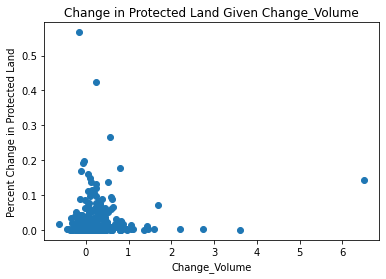

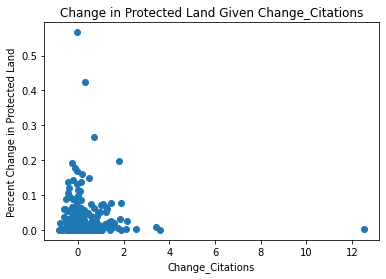

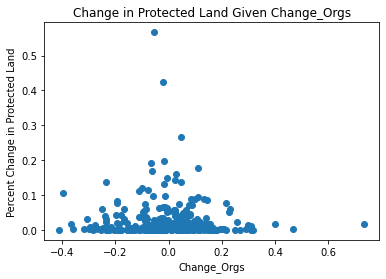

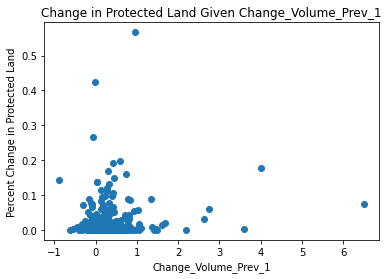

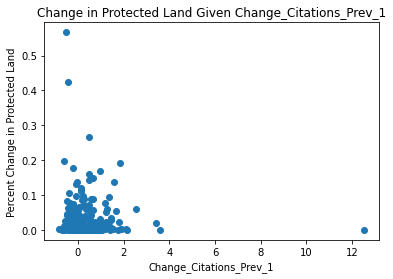

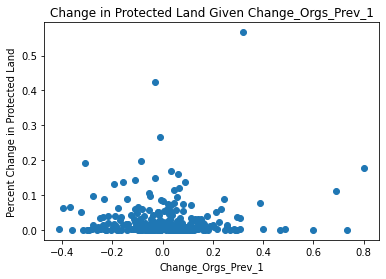

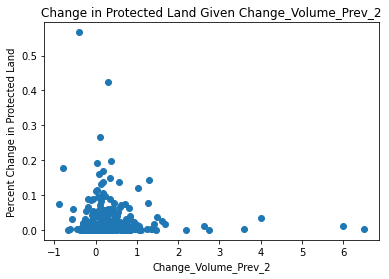

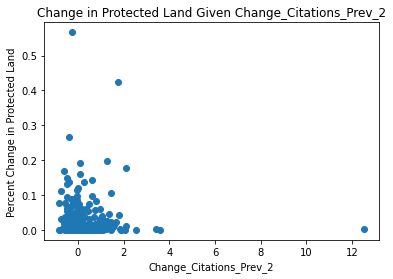

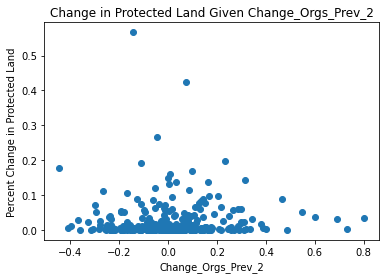

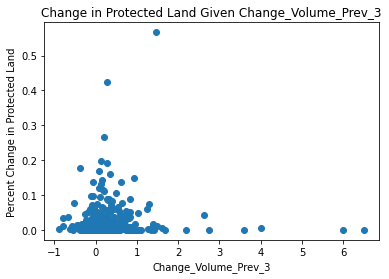

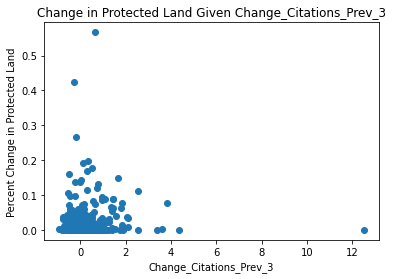

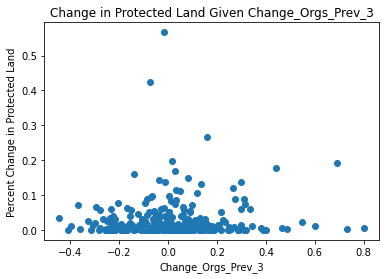

In [209]:
import matplotlib.pyplot as plt

for column_name in X_train_agg.columns:
    plt.scatter(X_train_agg[column_name], y_train_agg)
    plt.title(f'Change in Protected Land Given {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Percent Change in Protected Land')
    plt.show()

In [364]:
# run lasso regression over each country, compute the mean model and then measure performance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

linear_regr = LinearRegression().fit(X_train_agg, np.ravel(y_train_agg))
ridge_regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_train_agg, np.ravel(y_train_agg))
lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_train_agg, np.ravel(y_train_agg))
elastic_regr = ElasticNetCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_train_agg, np.ravel(y_train_agg))

print(f'Linear Regression MSE: {calc_MSE(linear_regr.predict(X_test_agg), np.array(y_test_agg))}')
print(f'Linear Regression MAE: {calc_MAE(linear_regr.predict(X_test_agg), y_test_agg)}')
print(f'Linear Regression R^2: {linear_regr.score(X_test_agg, y_test_agg)}')
print(f'\nRidge Regression MSE: {calc_MSE(ridge_regr.predict(X_test_agg), y_test_agg)}')
print(f'Ridge Regression MAE: {calc_MAE(ridge_regr.predict(X_test_agg), y_test_agg)}')
print(f'Ridge Regression R^2: {ridge_regr.score(X_test_agg, y_test_agg)}')
print(f'\nLasso Regression MSE: {calc_MSE(lasso_regr.predict(X_test_agg), y_test_agg)}')
print(f'Lasso Regression MAE: {calc_MAE(lasso_regr.predict(X_test_agg), y_test_agg)}')
print(f'Lasso Regression R^2: {lasso_regr.score(X_test_agg, y_test_agg)}')
print(f'\nElastic Net Regression MSE: {calc_MSE(elastic_regr.predict(X_test_agg), y_test_agg)}')
print(f'Elastic Net Regression MAE: {calc_MAE(elastic_regr.predict(X_test_agg), y_test_agg)}')
print(f'Elastic Net Regression R^2: {elastic_regr.score(X_test_agg, y_test_agg)}')

Linear Regression MSE: 0.04043267734880137
Linear Regression MAE: 1.5589633129010791
Linear Regression R^2: -10.915316194505664

Ridge Regression MSE: 0.03439887956179325
Ridge Regression MAE: 1.4439471750045894
Ridge Regression R^2: -9.10687394138902

Lasso Regression MSE: 0.03471061742629714
Lasso Regression MAE: 1.4516757666524784
Lasso Regression R^2: -9.204670053762237

Elastic Net Regression MSE: 0.03471061742629714
Elastic Net Regression MAE: 1.4516757666524784
Elastic Net Regression R^2: -9.204670053762237


In [248]:
ridge_regr.coef_

array([ 0.00301604, -0.00032511, -0.00048189,  0.00562133, -0.00120771,
        0.00097045, -0.00235132, -0.00091983,  0.00029603, -0.00030066,
        0.00173066,  0.00206426])

In [359]:
# lets try a GAM with natural cubic splines
import patsy as pat
import statsmodels.api as sm
import itertools

max_degs_of_freedom = 2
optimal_degs_freedom = []
optimal_MSE = np.inf
optimal_formula = 0
optimal_model = 0

for degs_freedom_list in itertools.product(range(1, max_degs_of_freedom + 1), repeat=len(X_train_agg.columns)):
    formula = ''
    for index, col_str in enumerate(X_train_agg.columns):
        formula = formula + 'cr(' + col_str + ', df='+ str(int(3 + degs_freedom_list[index])) + ') +'
    formula = formula[:-1]

    X_spline_train = pat.dmatrix(formula, X_train_agg)
    X_spline_test = pat.dmatrix(formula, X_test_agg)

    # build linear regression model
    spline_model = sm.OLS(y_train_agg, X_spline_train,).fit(disp=0)
    mse = calc_MSE(spline_model.predict(X_spline_test), y_test_agg)

    if mse < optimal_MSE:
        optimal_MSE = mse
        optimal_degs_freedom = degs_freedom_list
        optimal_formula = formula
        optimal_model = spline_model

print(f'Optimal MSE of {optimal_MSE} with optimal degrees of freedom given by the following list:')
print(optimal_degs_freedom)

Optimal MSE of 0.07643910451471146 with optimal degrees of freedom given by the following list:
(2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1)


In [365]:
X_test_spline = pat.dmatrix(optimal_formula, X_test_agg)
y_pred = optimal_model.predict(X_test_spline)
calc_MAE(y_pred, y_test_agg)

1.7066608386635989

In [303]:
def confidence_interval(X, y, y_pred):
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_pred - y)) / y.size
    cov = mse * np.linalg.inv(X.T @ X)
    # Alternatively the covariance could be found using StatsModels:
    # cov = model.cov_params()

    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)

    # Derive standard error of f(x) from variance
    se       = np.sqrt(abs(var_f))
    conf_int = 2*se

    return conf_int

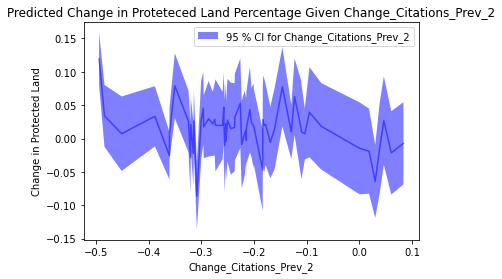

In [361]:
X_test_spline = pat.dmatrix(optimal_formula, X_test_agg)
y_pred = optimal_model.predict(X_test_spline)
conf_int = confidence_interval(X_test_spline, np.ravel(y_test_agg), np.array(y_pred))
y_pred_df = pd.DataFrame(dict({'Predicted_Change': y_pred}))
X_plot = pd.concat([X_test_agg, y_pred_df], axis=1)
X_plot = X_plot.sort_values(by=['Change_Citations_Prev_2'])
plt.plot(X_plot['Change_Citations_Prev_2'].to_numpy(), X_plot['Predicted_Change'].to_numpy(), c='b', alpha = 0.5)
plt.fill_between(x=X_plot['Change_Citations_Prev_2'].to_numpy(), y1=X_plot['Predicted_Change'].to_numpy()-conf_int, y2=X_plot['Predicted_Change'].to_numpy()+conf_int, facecolor = 'b', alpha = 0.5, label = '95 % CI for Change_Citations_Prev_2')
plt.xlabel('Change_Citations_Prev_2')
plt.ylabel('Change in Protected Land')
plt.title('Predicted Change in Proteteced Land Percentage Given Change_Citations_Prev_2')
plt.legend()
plt.show()

Ridge Regression models have lowest MSE of feature-based methods

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-326.950, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-231.539, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-310.147, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-260.121, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-333.812, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-335.601, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-333.864, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-331.864, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-338.586, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-323.879, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-337.435, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-337.317, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-329.473, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-335.396, Time=0.17 sec

Best model:  ARIMA(2,0,0)(0,0,0)

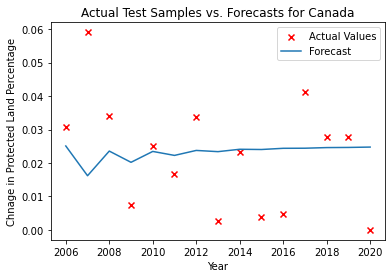

In [341]:
# train the ARIMA model

import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# run ARIMA on Canada data from 2000 onwards
protected_df = pd.read_csv('protected_land_cleaned.csv')
canada_percentages = protected_df[protected_df['Country'] == 'Canada']
canada_percentages = canada_percentages.reset_index(drop=True)
canada_time_series = pd.DataFrame(dict({'Year': np.array(range(1950, 2022)), 'Percent_Change': np.full_like(np.arange(72), np.nan, dtype=np.double)}))

for index, raw_year in enumerate(canada_percentages['Year']):
    canada_time_series.iloc[raw_year - 1950] = [raw_year, canada_percentages['Value'].iloc[index]]

# interpolate the values
canada_time_series['Percent_Change'] = canada_time_series['Percent_Change'].interpolate()
canada_time_series['Percent_Change'] = canada_time_series['Percent_Change'].pct_change()

train, test = model_selection.train_test_split(canada_time_series['Percent_Change'][1:], train_size=0.8)


arima = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=10, max_q=10,
                             start_P=0,
                             trace=True, seasonal=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


x = np.arange(test.shape[0])
plt.scatter(2021 - len(x) + x, test, color='r', marker='x', label='Actual Values')
plt.plot(2021 - len(x) + x, arima.predict(n_periods=test.shape[0]), label='Forecast')
plt.title('Actual Test Samples vs. Forecasts for Canada')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Chnage in Protected Land Percentage')
plt.show()

In [342]:
calc_MSE(arima.predict(n_periods=test.shape[0]), np.array(canada_percentages['Value'].tail(len(test) + 1).pct_change())[1:])

0.00029396410615514806

Unfortunately, it appears that ARIMA methods have the lowest MSE overall

In [15]:
import geopandas as geopandas

In [118]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['Protected Change'] = [np.nan] * len(world)
world['Change Citations'] = [np.nan] * len(world)

for i in range(len(y_train_list)):
    country_index = world.index[world['name'] == countries[i]].tolist()[0]
    world.at[country_index, 'Protected Change'] = y_train_list[i].iloc[-2]
    world.at[country_index, 'Change Citations'] = X_shifted_train_list[i]['Change_Citations'].iloc[-2]

<AxesSubplot:>

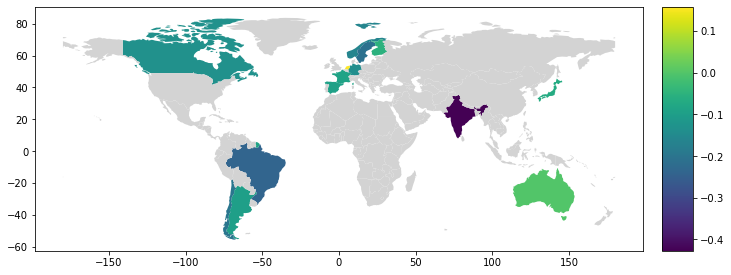

In [120]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='Change Citations', ax=ax, missing_kwds={'color': 'lightgrey'}, legend=True, cax=cax)

In [59]:
y_train_agg

,Change_Protected_Percent
3,0.160458
4,0.031886
5,0.042320
6,0.075777
7,0.042099
...,...
11,0.000032
12,0.000181
13,0.000186
14,0.019202


In [7]:
# get sorted order of countries by research volume
protected_df = pd.read_csv('protected_land_cleaned.csv')
country_len_df = pd.DataFrame(dict({'Country': np.zeros(len(protected_df["Country"].unique())), 'Paper_Count': np.zeros(len(protected_df["Country"].unique()))}))
for index, country_str in enumerate(protected_df["Country"].unique()):
    country_df = pd.read_csv(f'{country_str}_biodiversity_research.csv')
    country_len_df.iloc[index] = [country_str, len(country_df)]
    
country_len_df = country_len_df.sort_values(by=['Paper_Count'], ascending=False)
country_len_df = country_len_df.reset_index(drop=True)
country_len_df['Country'].to_numpy()

C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/2407573969.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country_str}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/2407573969.py:5: DtypeWarning: Columns (11,15,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country_str}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/2407573969.py:5: DtypeWarning: Columns (6,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country_str}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/2407573969.py:5: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country_str}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipy

array(['Germany', 'France', 'Australia', 'Brazil', 'Italy', 'Spain',
       'Canada', 'Netherlands', 'Switzerland', 'India', 'Sweden',
       'South Africa', 'Mexico', 'Japan', 'Belgium', 'Russia', 'Poland',
       'Portugal', 'Finland', 'Czech Republic', 'Denmark', 'New Zealand',
       'Austria', 'Argentina', 'Norway', 'Indonesia', 'Chile', 'World',
       'Colombia', 'Korea', 'Greece', 'Hungary', 'Ireland', 'Georgia',
       'Romania', 'Israel', 'Peru', 'Ecuador', 'Estonia', 'Costa Rica',
       'Slovenia', 'Saudi Arabia', 'Croatia', 'Bulgaria', 'Ukraine',
       'Lithuania', 'Uruguay', 'Puerto Rico', 'G7', 'Latvia',
       'Luxembourg', 'Cyprus', 'New Caledonia', 'Iceland',
       'French Guiana', 'Montserrat', 'Jersey', 'Kazakhstan', 'Malta',
       'Armenia', 'Belarus', 'APEC', 'Guadeloupe', 'Uzbekistan',
       'Paraguay', 'Guam', 'Moldova', 'Greenland', 'Kyrgyzstan',
       'Azerbaijan', 'Martinique', 'G20', 'United Kingdom', 'Tajikistan',
       'Bermuda', 'Anguilla', 'ASEAN',

100% (50 of 50) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


<Figure size 432x288 with 0 Axes>

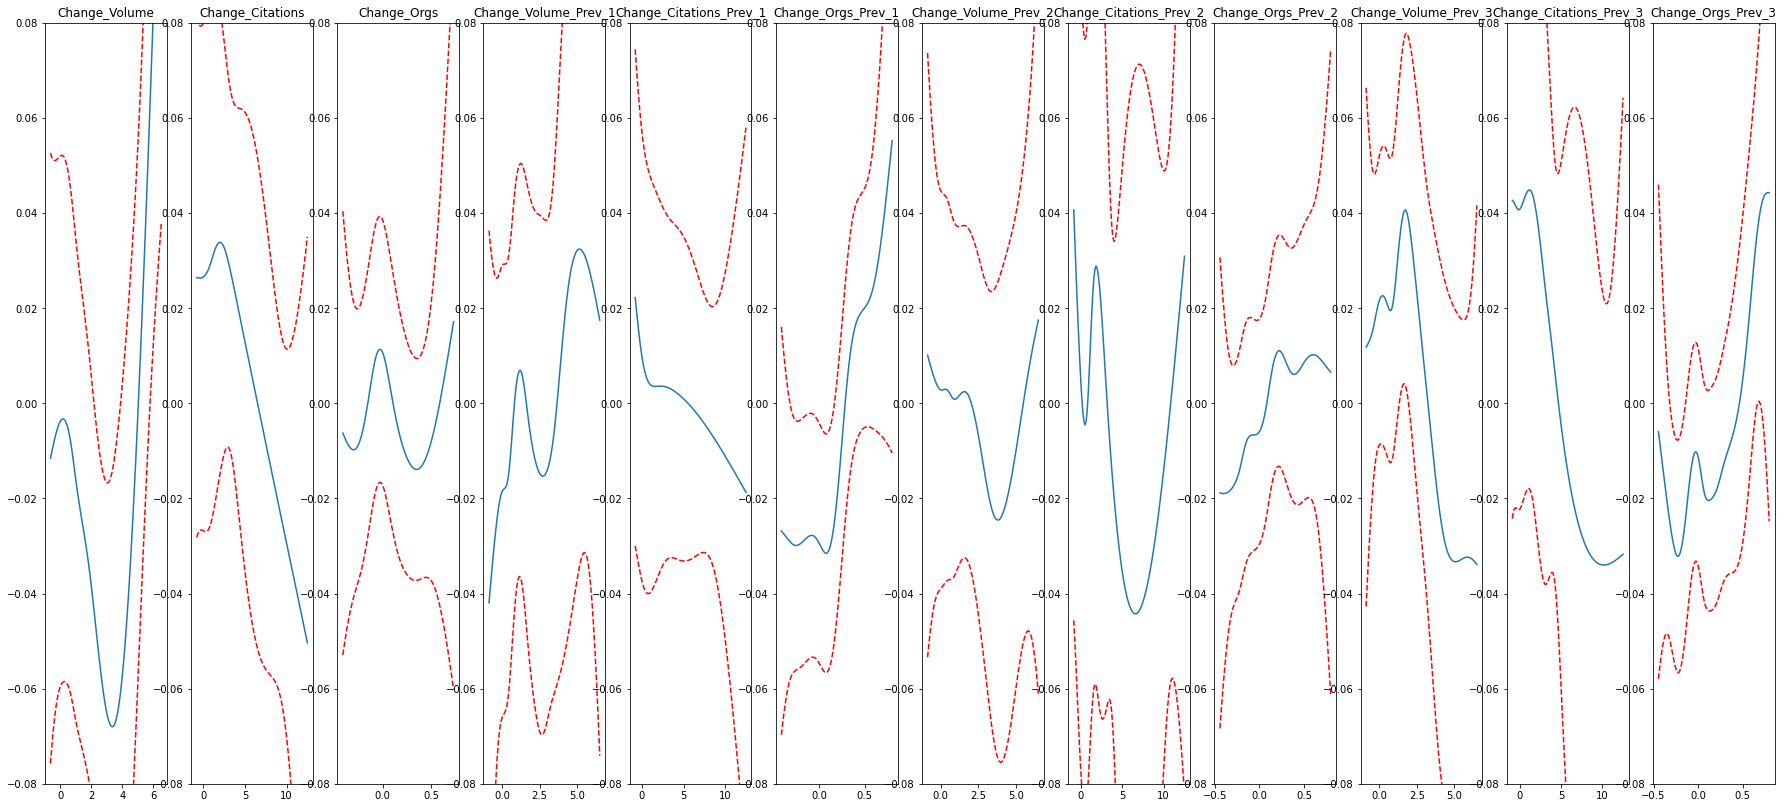

In [239]:
# expirementation with PyGAM
from pygam import LinearGAM
from pygam.datasets import wage

## model
lams = np.exp(np.random.rand(50, 12) * 6 - 3)
gam = LinearGAM()
gam.gridsearch(X_train_agg.to_numpy(), np.ravel(y_train_agg), lam=lams, keep_best=True)


## plotting
plt.figure()
fig, axs = plt.subplots(1,12, figsize=(31, 14))

titles = X_train_agg.columns
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), label='Predicted Dependence')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--', label='95 % Confidence Interval')
    ax.set_ylim(-0.08,0.08)
    ax.set_title(titles[i])

In [240]:
calc_MSE(gam.predict(X_test_agg), y_test_agg)

0.19840029577385104

In [241]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     55.2007
Link Function:                     IdentityLink Log Likelihood:                                -44595.5401
Number of Samples:                          310 AIC:                                            89303.4818
                                                AICc:                                           89328.9148
                                                GCV:                                                 0.004
                                                Scale:                                              0.0028
                                                Pseudo R-Squared:                                   0.2154
Feature Function                  Lam

C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [163]:
# correlation matrices
import seaborn as sb
import matplotlib.pyplot as plt

corr = X_train_agg.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\btiv\AppData\Local\Temp/ipykernel_8204/2473048969.py:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,Change_Volume,Change_Citations,Change_Orgs,Change_Volume_Prev_1,Change_Citations_Prev_1,Change_Orgs_Prev_1,Change_Volume_Prev_2,Change_Citations_Prev_2,Change_Orgs_Prev_2,Change_Volume_Prev_3,Change_Citations_Prev_3,Change_Orgs_Prev_3
Change_Volume,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Change_Citations,0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Change_Orgs,-0.03,-0.06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Change_Volume_Prev_1,-0.22,0.02,-0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan
Change_Citations_Prev_1,-0.02,-0.22,0.06,0.04,nan,nan,nan,nan,nan,nan,nan,nan
Change_Orgs_Prev_1,0.09,0.14,-0.31,0.09,-0.03,nan,nan,nan,nan,nan,nan,nan
Change_Volume_Prev_2,0.09,0.05,0.16,-0.26,0.03,-0.10,nan,nan,nan,nan,nan,nan
Change_Citations_Prev_2,0.12,0.12,-0.05,0.02,-0.23,0.08,0.01,nan,nan,nan,nan,nan
Change_Orgs_Prev_2,0.01,0.02,-0.10,0.03,0.13,-0.33,0.14,-0.05,nan,nan,nan,nan
Change_Volume_Prev_3,0.05,0.00,-0.10,0.08,0.04,0.14,-0.28,0.03,-0.09,nan,nan,nan
